In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import tensorflow as tf

/home/alvaro/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
pipeline = pd.read_csv('Pipeline Mock Data.csv')

In [4]:
pipeline.head()

,Key,OpportunityKey,Business_Line,Fundraise_Name,Adviser_Or_Direct,Adviser_Code,Investor_Code,Intermediary_Code,OpportunityStatus
0,1,757,IHT,Fundraiser_1,Direct,CON55826,CON47206,COM87187,Lost
1,2,792,AIM,Fundraiser_1,Direct,CON24585,CON30574,COM54565,Won
2,3,7,Labs,Fundraiser_5,Direct,CON86314,CON20624,COM86775,Lost
3,4,993,Labs,Fundraiser_0,Adviser,CON21625,CON48922,COM42671,Won
4,5,968,OITS,Fundraiser_7,Direct,CON57508,CON98028,COM60911,Lost


** TensorFlow won't be able to understand strings as labels, you'll need to use pandas .apply() method to apply a custom function that converts them to 0s and 1s. This might be hard if you aren't very familiar with pandas, so feel free to take a peek at the solutions for this part.**

** Convert the Label column to 0s and 1s instead of strings.**

In [5]:
pipeline['OpportunityStatus'].unique()

array(['Lost', 'Won'], dtype=object)

In [6]:
def label_fix(label):
    if label == 'Won':
        return 1
    return 0

In [7]:
pipeline['OpportunityStatus'] = pipeline['OpportunityStatus'].apply(lambda x:label_fix(x))

In [8]:
pipeline['OpportunityStatus'].unique()

array([0, 1])

### Perform a Train Test Split on the Data

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = pipeline.drop(['OpportunityStatus', 'Key', 'OpportunityKey'], axis=1)
y = pipeline['OpportunityStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Feature Columns

In [11]:
X.columns

Index(['Business_Line', 'Fundraise_Name', 'Adviser_Or_Direct', 'Adviser_Code',
       'Investor_Code', 'Intermediary_Code'],
      dtype='object')

In [12]:
business_line = tf.feature_column.categorical_column_with_vocabulary_list('Business_Line', X['Business_Line'].unique())
fundraise_name = tf.feature_column.categorical_column_with_vocabulary_list('Fundraise_Name', X['Fundraise_Name'].unique())
adviser_or_direct = tf.feature_column.categorical_column_with_vocabulary_list('Adviser_Or_Direct', X['Adviser_Or_Direct'].unique())
adviser_code = tf.feature_column.categorical_column_with_vocabulary_list('Adviser_Code', X['Adviser_Code'].unique())
investor_code = tf.feature_column.categorical_column_with_vocabulary_list('Investor_Code', X['Investor_Code'].unique())
intermediary_code = tf.feature_column.categorical_column_with_vocabulary_list('Intermediary_Code', X['Intermediary_Code'].unique())

In [13]:
feat_cols = [business_line, fundraise_name, adviser_or_direct, adviser_code, investor_code, intermediary_code]

### Create Input Function

In [14]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train, batch_size=10, shuffle=True)

In [29]:
model = tf.estimator.LinearClassifier(feature_columns=feat_cols, n_classes=2)
#model = tf.estimator.BoostedTreesClassifier(feature_columns=feat_cols, n_classes=2, n_batches_per_layer=10)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpo0d4nv0_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe0eb780630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [30]:
model.train(input_fn=input_func, steps=5000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpo0d4nv0_/model.ckpt.
INFO:tensorflow:loss = 6.931472, step = 1
INFO:tensorflow:Saving checkpoints for 7 into /tmp/tmpo0d4nv0_/model.ckpt.
INFO:tensorflow:Loss for final step: 7.0054646.


### Evaluation

In [17]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, shuffle=False)

In [18]:
predictions = list(model.predict(input_fn=pred_input_func))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpcgr94ed3/model.ckpt-7
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Each item will look like this:

In [19]:
predictions[0]

{'class_ids': array([1]),
 'classes': array([b'1'], dtype=object),
 'logistic': array([0.5407273], dtype=float32),
 'logits': array([0.16327101], dtype=float32),
 'probabilities': array([0.45927265, 0.5407273 ], dtype=float32)}

** Create a list of only the class_ids key values from the prediction list of dictionaries, these are the predictions you will use to compare against the real y_test values. **

In [20]:
final_preds = [pred['class_ids'][0] for pred in predictions]

In [21]:
final_preds[:10]

[1, 0, 0, 1, 0, 0, 1, 1, 0, 0]

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, final_preds))

             precision    recall  f1-score   support

          0       0.41      0.54      0.47        13
          1       0.54      0.41      0.47        17

avg / total       0.48      0.47      0.47        30



So bad! But again, this is mock data

## How can I assess which features are the most important?

In [23]:
model.get_variable_names()

['global_step',
 'linear/linear_model/Adviser_Code/weights',
 'linear/linear_model/Adviser_Code/weights/part_0/Ftrl',
 'linear/linear_model/Adviser_Code/weights/part_0/Ftrl_1',
 'linear/linear_model/Adviser_Or_Direct/weights',
 'linear/linear_model/Adviser_Or_Direct/weights/part_0/Ftrl',
 'linear/linear_model/Adviser_Or_Direct/weights/part_0/Ftrl_1',
 'linear/linear_model/Business_Line/weights',
 'linear/linear_model/Business_Line/weights/part_0/Ftrl',
 'linear/linear_model/Business_Line/weights/part_0/Ftrl_1',
 'linear/linear_model/Fundraise_Name/weights',
 'linear/linear_model/Fundraise_Name/weights/part_0/Ftrl',
 'linear/linear_model/Fundraise_Name/weights/part_0/Ftrl_1',
 'linear/linear_model/Intermediary_Code/weights',
 'linear/linear_model/Intermediary_Code/weights/part_0/Ftrl',
 'linear/linear_model/Intermediary_Code/weights/part_0/Ftrl_1',
 'linear/linear_model/Investor_Code/weights',
 'linear/linear_model/Investor_Code/weights/part_0/Ftrl',
 'linear/linear_model/Investor_Code/

In [24]:
wt_vals = [model.get_variable_value(name) for name in model.get_variable_names()[1:]]

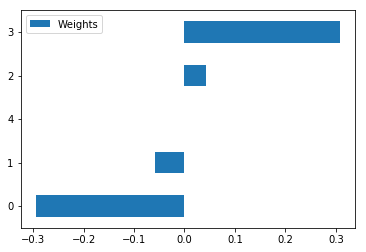

In [34]:
business_line_weights = model.get_variable_value('linear/linear_model/Business_Line/weights').flatten()
keys = pipeline['Business_Line'].value_counts().keys()

pd.DataFrame({'Weights':business_line_weights}).sort_values('Weights', ascending=True).plot(kind="barh", grid=False);


This implies the likelihood of an opportunity being won (according to the model), based on the Business Line feature